# Environment Setup

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [1]:
"""
Change directory to where this file is located
"""
%cd "/content/drive/MyDrive/data"

/content/drive/MyDrive/data


In [5]:
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0
!pip install torchtext==0.16.0
!pip install portalocker>=2.0.0 # 해당 셀 실행 이후 '런타임 > 런타임 다시 시작' 후 위에서부터 다시 실행

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 100.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 77.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux

In [3]:
%load_ext tensorboard

In [2]:
import time
import math
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from typing import List, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.data.functional import to_map_style_dataset

In [ ]:
"""
import modules you need
"""


'\nimport modules you need\n'

In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using PyTorch version: {}, Device: {}".format(torch.__version__, DEVICE))
print("Using torchtext version: {}".format(torchtext.__version__))

Using PyTorch version: 2.1.0+cu121, Device: cuda
Using torchtext version: 0.16.0+cpu


# Load Data

In [5]:
"""
Load AG_NEWS dataset and set up the tokenizer and encoder pipeline.

Do NOT modify.
"""

train_data, test_data = torchtext.datasets.AG_NEWS(root='./data')

tokenizer = get_tokenizer('basic_english')

def tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

encoder = build_vocab_from_iterator(tokens(train_data), specials=["<unk>"])
encoder.set_default_index(encoder["<unk>"])

text_pipeline = lambda x: encoder(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [6]:
def collate_batch(
    batch: List[Tuple[int, str]]
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Creates a batch of encoded text, label and token length tensors.

    Question (a)
    - The input texts in the batch have different lengths.
    - Complete your code to make them have same length using their average.
    - This means that the length of token sequence in each batch is determined by
      the average of token length of all sequences in each batch.
    - Text tensors are stacked with dimension of (TOKEN_LENGTH, BATCH),
      for easier process in RNN model.
    - Token length tensors are used to index the last valid hidden token for classification.

    Args:
      batch: list of tuples, each containing an integer label and a text input.
      - ex) [(3, "Wall St. Bears..."), (4, "Comtes, Asteroids and ..."), ...]
      - number of tuples in the list is same as BATCH SIZE.

    Returns:
      text_list: batch of encoded long type text tensors with size (TOKEN_LENGTH, BATCH)
      label_list: batch of label tensors with size (BATCH)
      len_list: batch of token length tensors with size (BATCH)
    """

    text_list, label_list, len_list = [], [], []

    ##### YOUR CODE #####
    _tmp_text_list = []
    for (_label, _text) in batch:
      label_list.append(label_pipeline(_label))
      text_tokenized = torch.tensor(text_pipeline(_text), dtype = torch.int64)
      _tmp_text_list.append(text_tokenized)
      len_list.append(text_tokenized.size(0))

    MAX_LEN = int(np.mean(len_list))

    for text_tokenized in _tmp_text_list:
      if text_tokenized.size(0) >= MAX_LEN :
        text_tokenized = text_tokenized[:MAX_LEN]
      else:
        text_tokenized = torch.cat([text_tokenized, torch.zeros(MAX_LEN-text_tokenized.size(0))])
      text_list.append(text_tokenized)

    text_list = torch.stack(text_list, dim=1)
    label_list = torch.tensor(label_list, dtype=torch.int64)
    len_list = torch.tensor(len_list, dtype=torch.int64)

    # sorting for efficient forwarding
    len_list, indicies = torch.sort(len_list)
    text_list = text_list.index_select(1, indicies)
    label_list = label_list.index_select(0, indicies)

    #####################

    assert text_list.size(1) == len(batch)

    return (text_list, label_list, len_list)

In [7]:
"""
Load the data loader.

Do NOT modify.
"""
BATCH_SIZE = 512

train_dataset = to_map_style_dataset(train_data)
test_dataset = to_map_style_dataset(test_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

In [8]:
"""
Print out the first batch in the train loader.
Check if the collate function is implemented correctly.

Do NOT modify.
"""

batch_x, batch_y, len_x = next(iter(train_dataloader))
print(batch_x[:10])
print(batch_y[:10])
print(len_x[:10])

tensor([[3.7900e+02, 7.7000e+01, 1.1660e+03,  ..., 9.0000e+00, 1.2752e+04,
         8.3600e+02],
        [1.4390e+03, 6.3450e+03, 2.4160e+03,  ..., 1.0000e+00, 1.1600e+02,
         4.3329e+04],
        [2.0185e+04, 1.0000e+01, 5.2020e+03,  ..., 4.2000e+02, 1.4112e+04,
         2.6330e+03],
        ...,
        [1.5537e+04, 1.7360e+03, 1.8100e+02,  ..., 2.7900e+02, 1.7200e+02,
         1.6160e+03],
        [1.2960e+03, 2.3000e+01, 4.0000e+00,  ..., 1.7300e+02, 1.4000e+01,
         5.6450e+03],
        [3.8370e+03, 1.4170e+03, 8.4940e+03,  ..., 1.8000e+01, 2.5820e+03,
         7.4000e+01]])
tensor([0, 3, 3, 1, 3, 2, 3, 0, 3, 3])
tensor([15, 17, 17, 18, 18, 18, 21, 22, 23, 24])


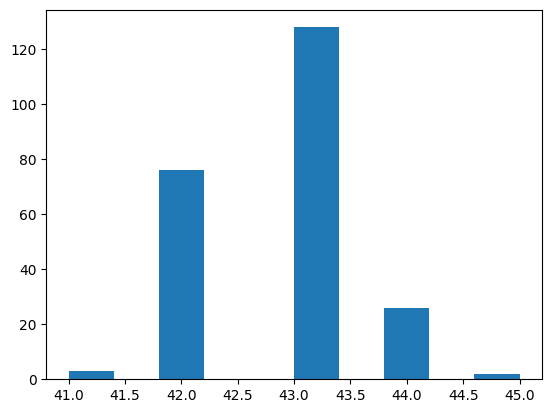

In [9]:
"""
Plot the sequence length distribution of the batches in the train dataloader.
Make sure that all batches have difference sequence lengths.

Do NOT modify.
"""

batch_len = []
for batch_x, _, _ in train_dataloader:
    seq_len = batch_x.size(0)
    batch_len.append(seq_len)
plt.hist(batch_len)
plt.show()

# Model

In [10]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        input_size: int,
        hidden_size: int,
        num_class: int,
        dropout_ratio: float,
    ):
        """
        Define the model weight parameters and initialize the weights.

        Question (b)
        - Complete the dimension and shape of the weights and biases.
        - Use the model parameters (vocab_size, input_size, hidden_size, num_class).

        Args:
          vocab_size: size of dictionary of vocabularies.
          input_size: size of each embedding vector.
          hidden_size: size of hidden dimension.
          num_class: size of output classes.
          dropout_ratio: probability of an element to be zeroed.
        """
        super(RNN, self).__init__()

        ##### YOUR CODE #####
        whh_size = (hidden_size, hidden_size)
        wxh_size = (hidden_size, input_size)
        why_size = (num_class, hidden_size)
        bhh_size = (hidden_size,1)
        bxh_size = (hidden_size,1)
        bhy_size = (num_class,1)
        #####################

        kwargs = {'device': DEVICE, 'dtype': torch.float}
        self.dropout = dropout_ratio
        self.hidden = hidden_size
        self.num_class = num_class
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.W_hh = nn.parameter.Parameter(torch.empty(whh_size, **kwargs))
        self.W_xh = nn.parameter.Parameter(torch.empty(wxh_size, **kwargs))
        self.W_hy = nn.parameter.Parameter(torch.empty(why_size, **kwargs))
        self.b_hh = nn.parameter.Parameter(torch.empty(bhh_size, **kwargs))
        self.b_xh = nn.parameter.Parameter(torch.empty(bxh_size, **kwargs))
        self.b_hy = nn.parameter.Parameter(torch.empty(bhy_size, **kwargs))

        self.init_parameters()

    def init_parameters(self):
        """
        Initialize the parameters with Kaiming uniform initialization.

        Do NOT modify this method.
        """
        nn.init.kaiming_uniform_(self.W_hh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_xh, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_xh)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_xh, -bound, bound)
        nn.init.kaiming_uniform_(self.W_hy, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_hy)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.b_hy, -bound, bound)

    def forward(self, inputs: torch.Tensor, length: torch.Tensor) -> torch.Tensor:
        """
        Question (c)
        - Randomly initialize h_0 with appropriate shape.
        - Pass a sequence of tokens into the recurrent network.
        - Implement dropout to embedded tokens with the given probability (self.dropout).
          For example, if self.dropout is 0.3, 30% of the embedded tokens will be dropped out.
        - We do not want to use a hidden cell of a zero-padded token for classification!
        - Index the hidden cell of the last valid token (excluding the zero-padding)
          based on the token length of each example in the batch.
        - Do NOT use pre-defined PyTorch layers for this question. (e.g. nn.RNN, nn.Dropout)

        Args:
          inputs: a batch of encoded token sequences with shape (SEQ_LEN, BATCH_SIZE)
          length: a batch of token lengths with shape (BATCH_SIZE)

        Returns:
          Softmax probabilites for each class with shape (BATCH_SIZE, NUM_CLASS)
        """

        ##### YOUR CODE #####
        def drop_out(X):
          mask = (torch.rand_like(X) > self.dropout)
          return X * mask / (1.0 - self.dropout)

        SEQ_LEN, BATCH_SIZE = inputs.size()
        inputs = inputs.long()
        embed_inputs = self.embedding(inputs) # (SEQ_LEN, BATCH_SIZE, input_size)

        h = torch.rand((self.hidden, BATCH_SIZE), device=inputs.device, dtype = torch.float)
        h_output = torch.zeros((self.hidden, BATCH_SIZE), device=inputs.device, dtype = torch.float)
        batch_indicator = 0

        """
        I make sure that the following code and algorithms are the algorithms that I thought of myself.
        In the following code, to implement and run the code more efficiently, I tried to use a single for-loop.
        I verified that using single for-loop is approximately 10 times fater than the naive implementation that uses two for-loops.

        Algorithms:
        I defined a variable "batch_indicator" which indicates the batch-index of "h_output" that is recently filled.
        "h_output" contains the hidden states that is arrived at the maximum iteration number (VALID_TOKEN_LEN)
        For each iteration on SEQ_LEN, it is checked whether the hidden state that batch_indicator indicates exceed its original length.
        It is clear that the hidden states that are located after the batch_indicator does not exceed thier original length since the inputs are ordered with respect to their original lengths.
        """

        for seq_idx in range(SEQ_LEN):
          embed_input = embed_inputs[seq_idx,:,:].T #(input_size, BATCH_SIZE)
          if self.training : # dropout should be only in training
            embed_input = drop_out(embed_input)
          embed_input = embed_input.float()

          h = F.tanh(self.W_hh @ h + self.b_hh + self.W_xh @ embed_input + self.b_xh) #(hidden_size, BATCH_SIZE)
          while length[batch_indicator].item() <= seq_idx: # drain the all hidden states that the number of iteration exceeds its original length
            h_output[:,batch_indicator] = h[:,batch_indicator]
            batch_indicator +=1

        h_output[:, batch_indicator:] = h[:,batch_indicator:]

        y = self.W_hy@h_output + self.b_hy
        softmax_probs = F.softmax(y, dim=1)

        return softmax_probs.T
        #####################

    def compute_loss(
        self,
        prediction: torch.Tensor,
        label: torch.Tensor) -> Tuple[torch.Tensor, int]:
        """
        Question (d)

        - Compute the cross entropy loss and the number of correct predictions
        - Do NOT use loss function in torch.nn library (e.g. nn.CrossEntropyLoss())

        Args:
          prediction: output(softmax probabilities) from self.forward function with shape (BATCH_SIZE, NUM_CLASS)
          label: integer labels of the batch inputs with shape (BATCH_SIZE)

        Returns:
          cross entropy loss of the batch (float tensor) and the number of correct predictions (integer)
        """
        ##### YOUR CODE #####
        BATCH_SIZE, NUM_CLASS = prediction.shape
        log_pred = torch.log(prediction)
        one_hot_labels = torch.zeros(prediction.shape).to(DEVICE) #(BATCH_SIZE, NUM_CLASS)
        for batch_idx in range(BATCH_SIZE):
          one_hot_labels[batch_idx,label[batch_idx]] = 1

        loss = -torch.sum(one_hot_labels * log_pred) / BATCH_SIZE

        _, pred_label = torch.max(prediction, 1)
        correct = torch.sum(pred_label == label).item()

        #####################
        return (loss, correct)

# Training Modules

In [11]:
class ScheduledOptim():
    """
    Learning rate scheduler.

    Do NOT modify.
    """

    def __init__(self, optimizer, n_warmup_steps, decay_rate):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.decay = decay_rate
        self.n_steps = 0
        self.initial_lr = optimizer.param_groups[0]['lr']
        self.current_lr = optimizer.param_groups[0]['lr']

    def zero_grad(self):
        self._optimizer.zero_grad()

    def step(self):
        self._optimizer.step()

    def get_lr(self):
        return self.current_lr

    def update(self):
        if self.n_steps < self.n_warmup_steps:
            lr = self.n_steps / self.n_warmup_steps * self.initial_lr
        elif self.n_steps == self.n_warmup_steps:
            lr = self.initial_lr
        else:
            lr = self.current_lr * self.decay

        self.current_lr = lr
        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr

        self.n_steps += 1

# Model Training

In [12]:
"""
Functions for training and evaluating the model.

Question (e)
- Compared to practice 3 (RNN Text Classification) covered in the lab session 3, there has been minor
  modification with scheduler and loss computation. Check what should have been changed, and complete
  the train and evaluate function that works for the current training pipeline
- Use the methods of the ScheduledOptim class above to perform necessary operations on the optimizer.
- Do NOT change the arguments given to the train, evaluate functions.
"""

def train(model, train_loader, scheduler):
    ##### YOUR CODE #####

    model.train()
    train_loss = 0
    correct = 0

    tqdm_bar = tqdm(train_loader)
    model.train()

    for text, label, length in tqdm_bar:
        text = text.to(DEVICE)
        label = label.to(DEVICE)
        length = length.to(DEVICE)

        scheduler.zero_grad()

        prediction = model.forward(text,length)
        _loss, _correct = model.compute_loss(prediction, label)
        correct += _correct
        train_loss += _loss

        _loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        scheduler.step()

    train_loss /= len(train_loader.dataset)
    train_acc = 100. * correct / len(train_loader.dataset)
    #####################

    return train_loss, train_acc


def evaluate(model, test_loader):
    ##### YOUR CODE #####
    model.eval()
    test_loss = 0
    correct = 0

    tqdm_bar = tqdm(test_loader)
    model.eval()

    with torch.no_grad():
        for text, label, length in tqdm_bar:
            text = text.to(DEVICE)
            label = label.to(DEVICE)
            length = length.to(DEVICE)

            prediction = model.forward(text,length)
            _loss, _correct = model.compute_loss(prediction,label)
            test_loss+=_loss
            correct+=_correct

    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)

    #####################
    return test_loss, test_acc

In [13]:

"""
Question (f)
- Train your RNN model and obtain the test accuracy of 70%.
- Select the input size, hidden size of your choice
- Try various optimizer type, learning rate and scheduler options for the best performance.
- Visualize your experiments with Tensorboard.
- Your TensorBoard results should include Train/Validation Loss and Accuracy.
"""

##### YOUR CODE #####
writer = SummaryWriter(log_dir="./logs")
EPOCHS = 20
BATCH_SIZE = 512
vocab_size = len(encoder)
input_size = 64
hidden_size = 64
num_class = len(set([label for (label, text) in train_data]))
dropout_ratio = 0.1
learning_rate = 0.001

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)

model = RNN(vocab_size, input_size, hidden_size, num_class, dropout_ratio).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
scheduler = ScheduledOptim(optimizer, 2 ,0.95)

for epoch in range(1, EPOCHS + 1):
    loss_train, accu_train = train(model, train_dataloader, scheduler)
    loss_val, accu_val = evaluate(model, valid_dataloader)

    lr = scheduler.get_lr()
    writer.add_scalar("Loss/train", loss_train, epoch)
    writer.add_scalar("Accuracy/train", accu_train, epoch)
    writer.add_scalar("Loss/val", loss_val, epoch)
    writer.add_scalar("Accuracy/val", accu_val, epoch)

    print('-' * 83)
    print('| end of epoch {:2d} | lr: {:5.4f} | train loss: {:8.3f} | train accuracy: {:8.3f} | '
          'valid accuracy {:8.3f} '.format(epoch, lr, loss_train, accu_train, accu_val))
    print('-' * 83)
    scheduler.update()

writer.flush()
writer.close()
#####################

  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  1 | lr: 0.0010 | train loss:    0.012 | train accuracy:   44.032 | valid accuracy   64.066 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  2 | lr: 0.0000 | train loss:    0.011 | train accuracy:   62.845 | valid accuracy   64.132 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  3 | lr: 0.0005 | train loss:    0.011 | train accuracy:   67.108 | valid accuracy   71.184 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  4 | lr: 0.0010 | train loss:    0.011 | train accuracy:   76.102 | valid accuracy   78.579 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  5 | lr: 0.0009 | train loss:    0.011 | train accuracy:   81.237 | valid accuracy   82.211 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  6 | lr: 0.0009 | train loss:    0.010 | train accuracy:   84.198 | valid accuracy   84.132 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  7 | lr: 0.0009 | train loss:    0.010 | train accuracy:   86.191 | valid accuracy   85.092 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  8 | lr: 0.0008 | train loss:    0.010 | train accuracy:   87.762 | valid accuracy   86.987 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch  9 | lr: 0.0008 | train loss:    0.010 | train accuracy:   88.612 | valid accuracy   87.158 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 10 | lr: 0.0007 | train loss:    0.010 | train accuracy:   89.594 | valid accuracy   87.934 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 11 | lr: 0.0007 | train loss:    0.010 | train accuracy:   90.278 | valid accuracy   88.211 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 12 | lr: 0.0007 | train loss:    0.010 | train accuracy:   90.803 | valid accuracy   88.618 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 13 | lr: 0.0006 | train loss:    0.010 | train accuracy:   91.308 | valid accuracy   89.026 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 14 | lr: 0.0006 | train loss:    0.010 | train accuracy:   91.597 | valid accuracy   88.750 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 15 | lr: 0.0006 | train loss:    0.010 | train accuracy:   92.038 | valid accuracy   89.368 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 16 | lr: 0.0005 | train loss:    0.010 | train accuracy:   92.396 | valid accuracy   89.355 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 17 | lr: 0.0005 | train loss:    0.010 | train accuracy:   92.573 | valid accuracy   89.474 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 18 | lr: 0.0005 | train loss:    0.010 | train accuracy:   92.860 | valid accuracy   89.645 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 19 | lr: 0.0005 | train loss:    0.010 | train accuracy:   93.130 | valid accuracy   89.105 
-----------------------------------------------------------------------------------


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

-----------------------------------------------------------------------------------
| end of epoch 20 | lr: 0.0004 | train loss:    0.010 | train accuracy:   93.292 | valid accuracy   89.053 
-----------------------------------------------------------------------------------


In [14]:
# (f) Visualize the experimental logs with TensorBoard
# Submission of the visualization result is not required.
%tensorboard --logdir ./logs

<IPython.core.display.Javascript object>